## Notes

We are likely overfitting here due to low sample size. For now, we keep this example for future reference as the procedure is valid.

### Imports

In [1]:
import logging
import sys
import os
import pandas as pd


sys.path.append(os.path.abspath(".."))

from scripts.database import get_session
from scripts.utils import load_config, setup_logging
from models import ACS2017CountyData, MortalityRate2014


### Config and Logging Setup

In [2]:
try:
    config = load_config()
    setup_logging(config['paths']['log_path'])
    logging.info("Starting the data analysis project.")
except Exception as e:
    logging.error(f"Failed to load config or setup logging: {e}")
    raise

INFO:root:Starting the data analysis project.
Starting the data analysis project.


### Database Session

In [3]:
try:
    session = get_session()
    logging.info("Database session created successfully.")
except Exception as e:
    logging.error(f"Failed to create database session: {e}")
    raise

INFO:root:Database session created successfully.
Database session created successfully.


### Query netflix Data

In [4]:
try:
    data = session.query(
        ACS2017CountyData.poverty,
        MortalityRate2014.mortality_rate_2014_max
        ).filter(ACS2017CountyData.fips_code == MortalityRate2014.fips_code)\
        .all()

    
    df = pd.DataFrame(data)
    print(df.head())
except Exception as e:
    logging.error(f"Failed to query show data: {e}")
    raise


   poverty  mortality_rate_2014_max
0     13.7                     5.21
1     11.8                     4.08
2     27.2                     6.24
3     15.2                     6.85
4     15.6                     4.06


### Visualize Data

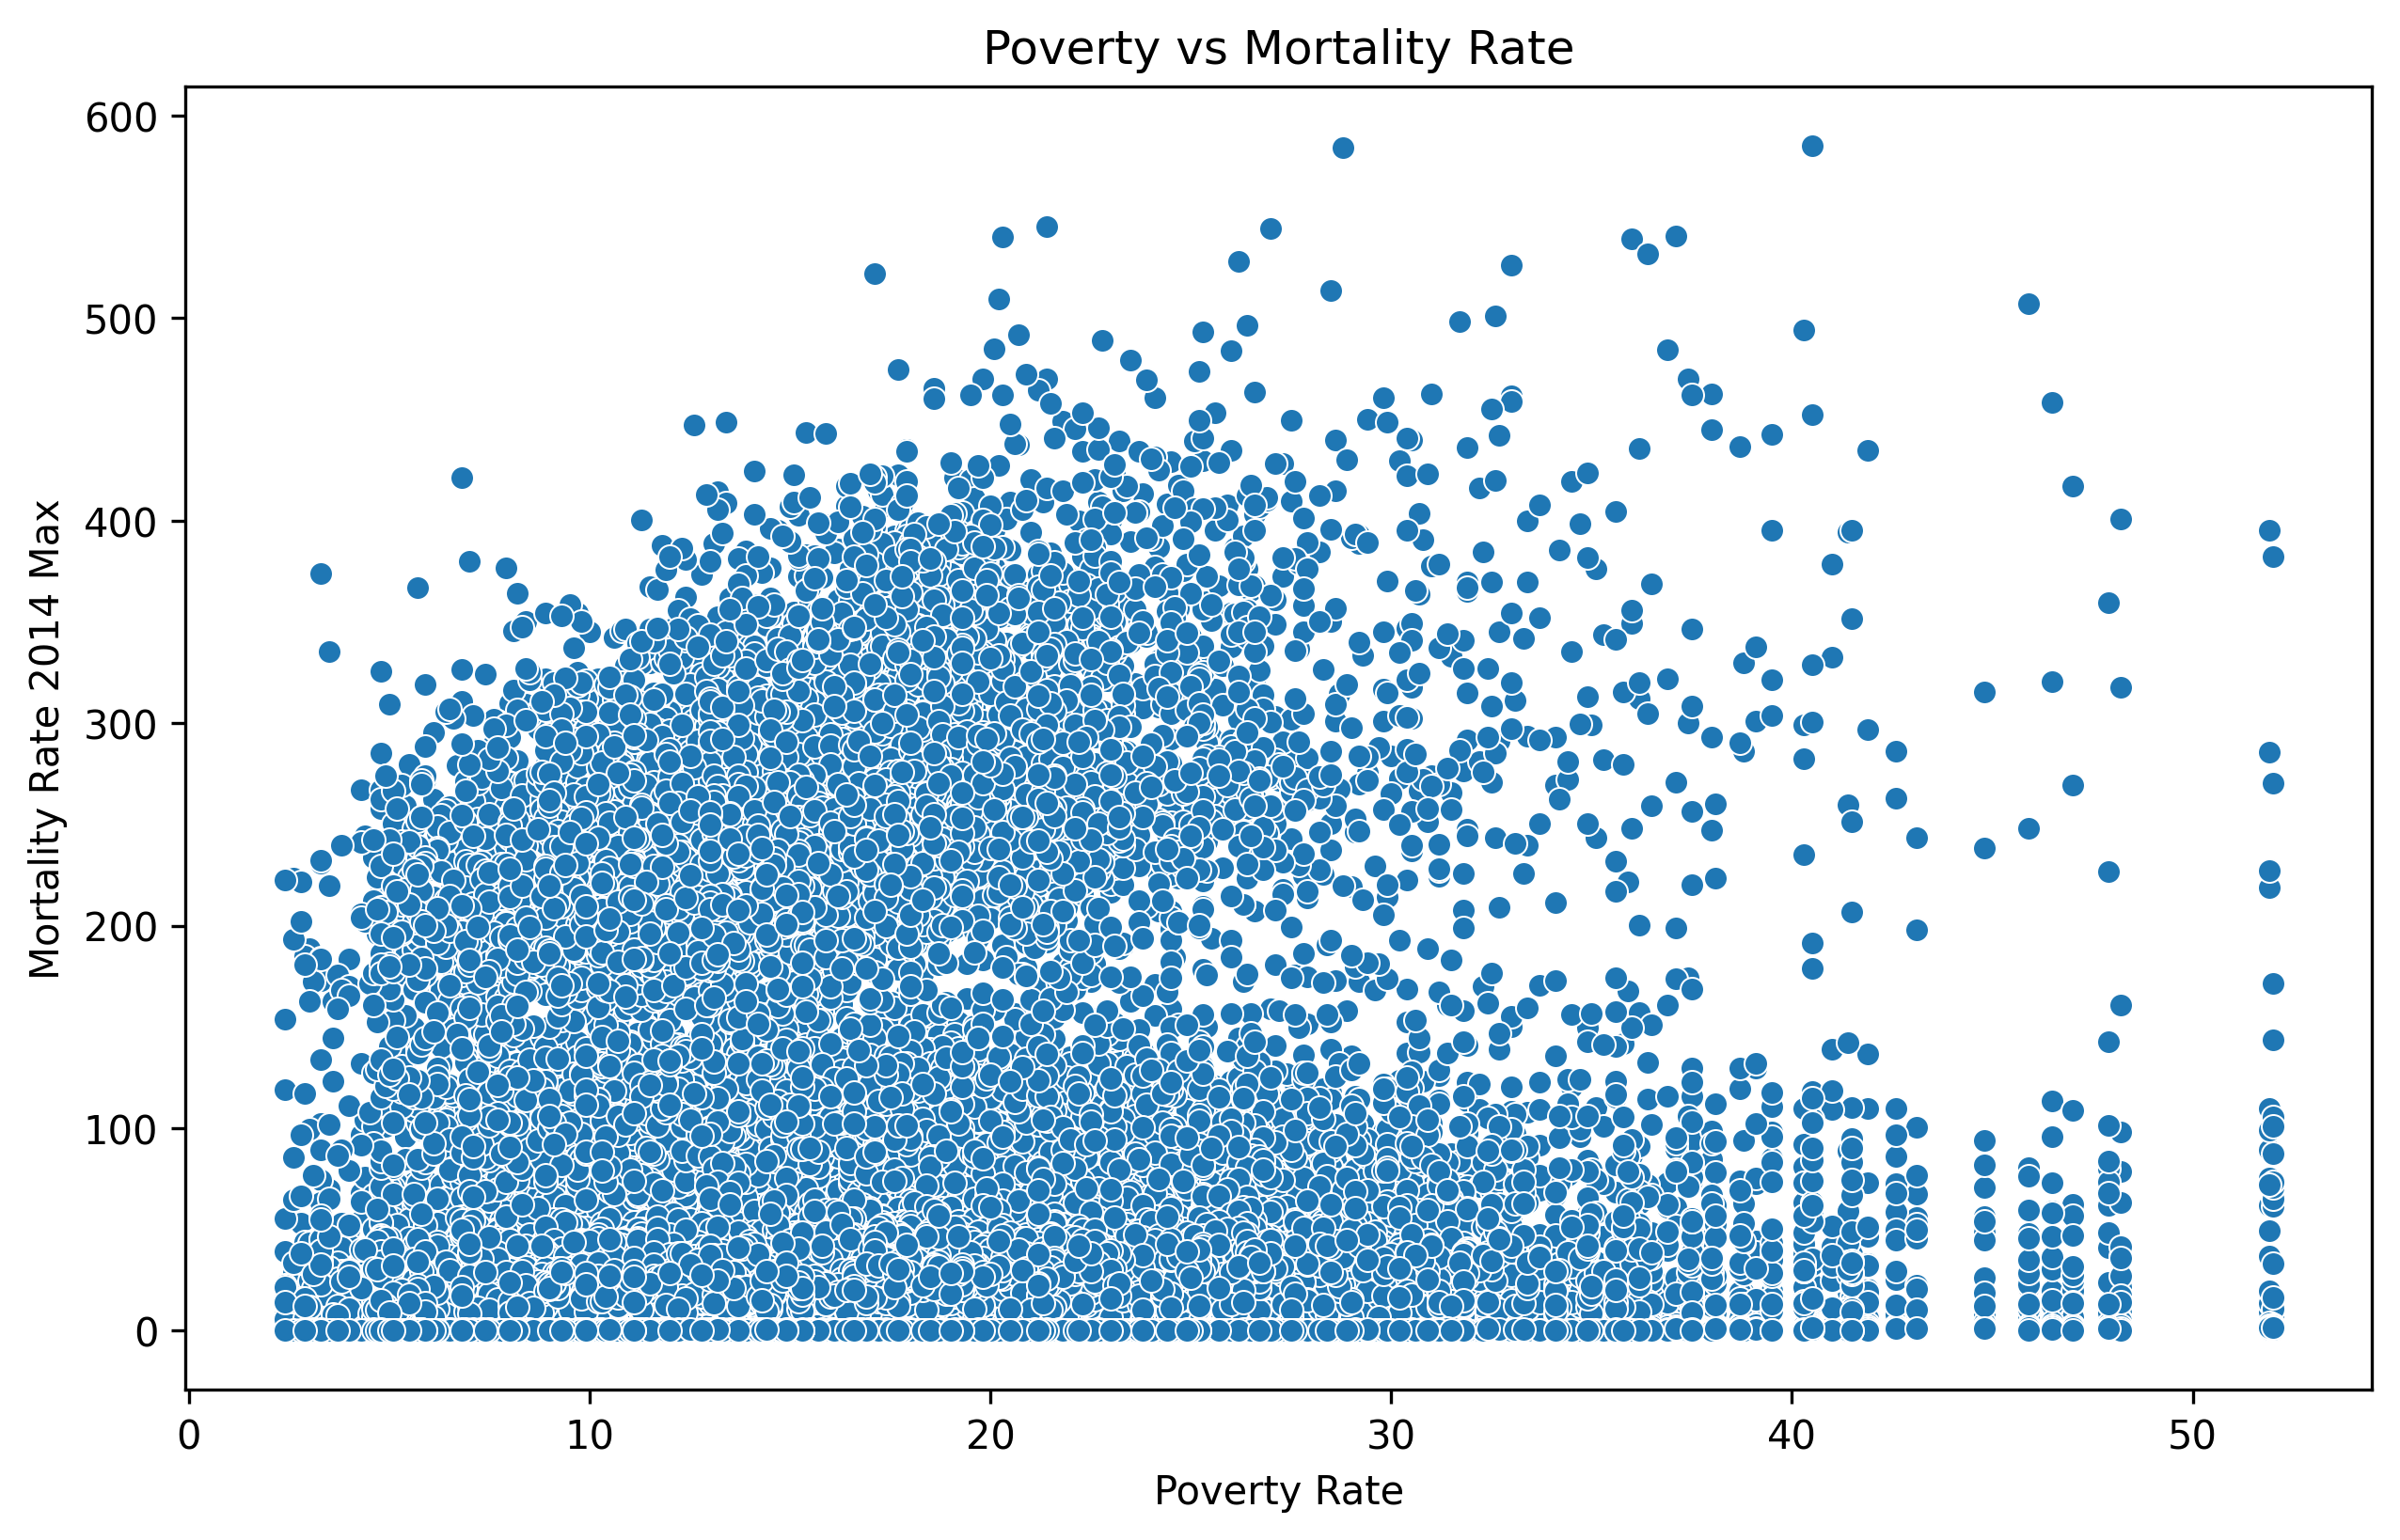

In [5]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plotting poverty versus mortality rate
plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x='poverty', y='mortality_rate_2014_max', data=df)
plt.title('Poverty vs Mortality Rate')
plt.xlabel('Poverty Rate')
plt.ylabel('Mortality Rate 2014 Max')
plt.show()

### Preprocess Data

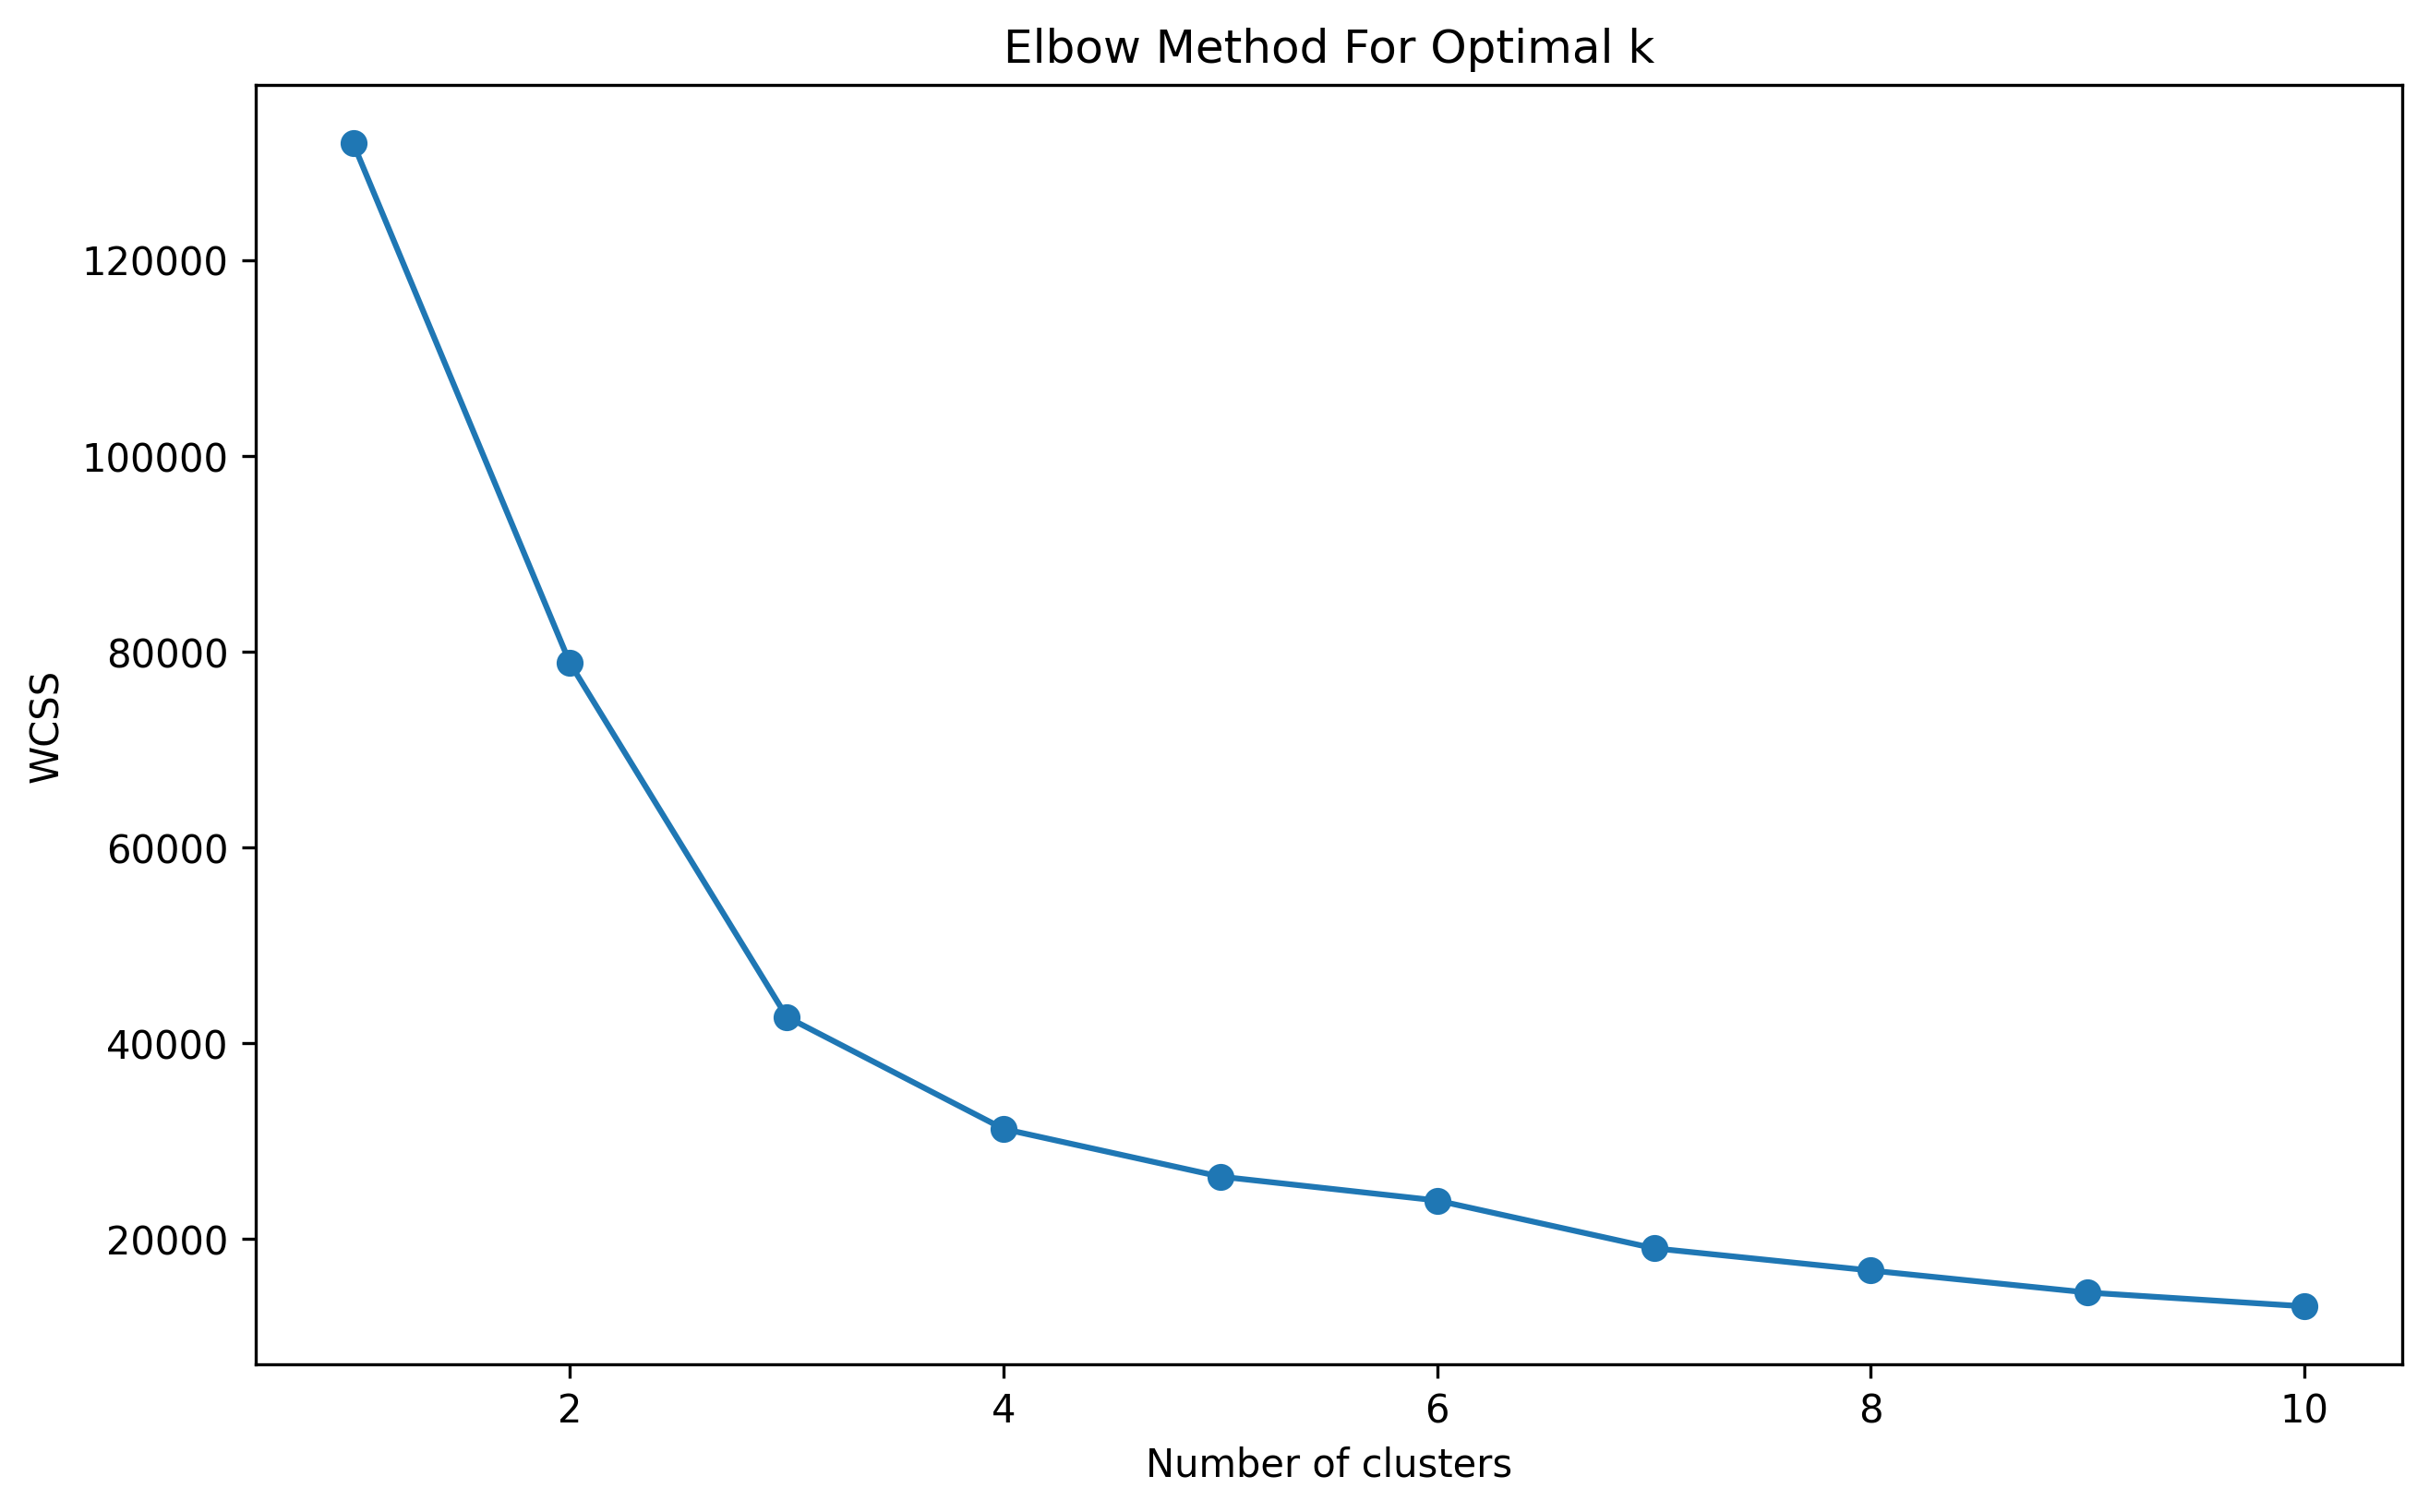

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = df.dropna()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Elbow method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the elbow plot
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



### K Means Clustering

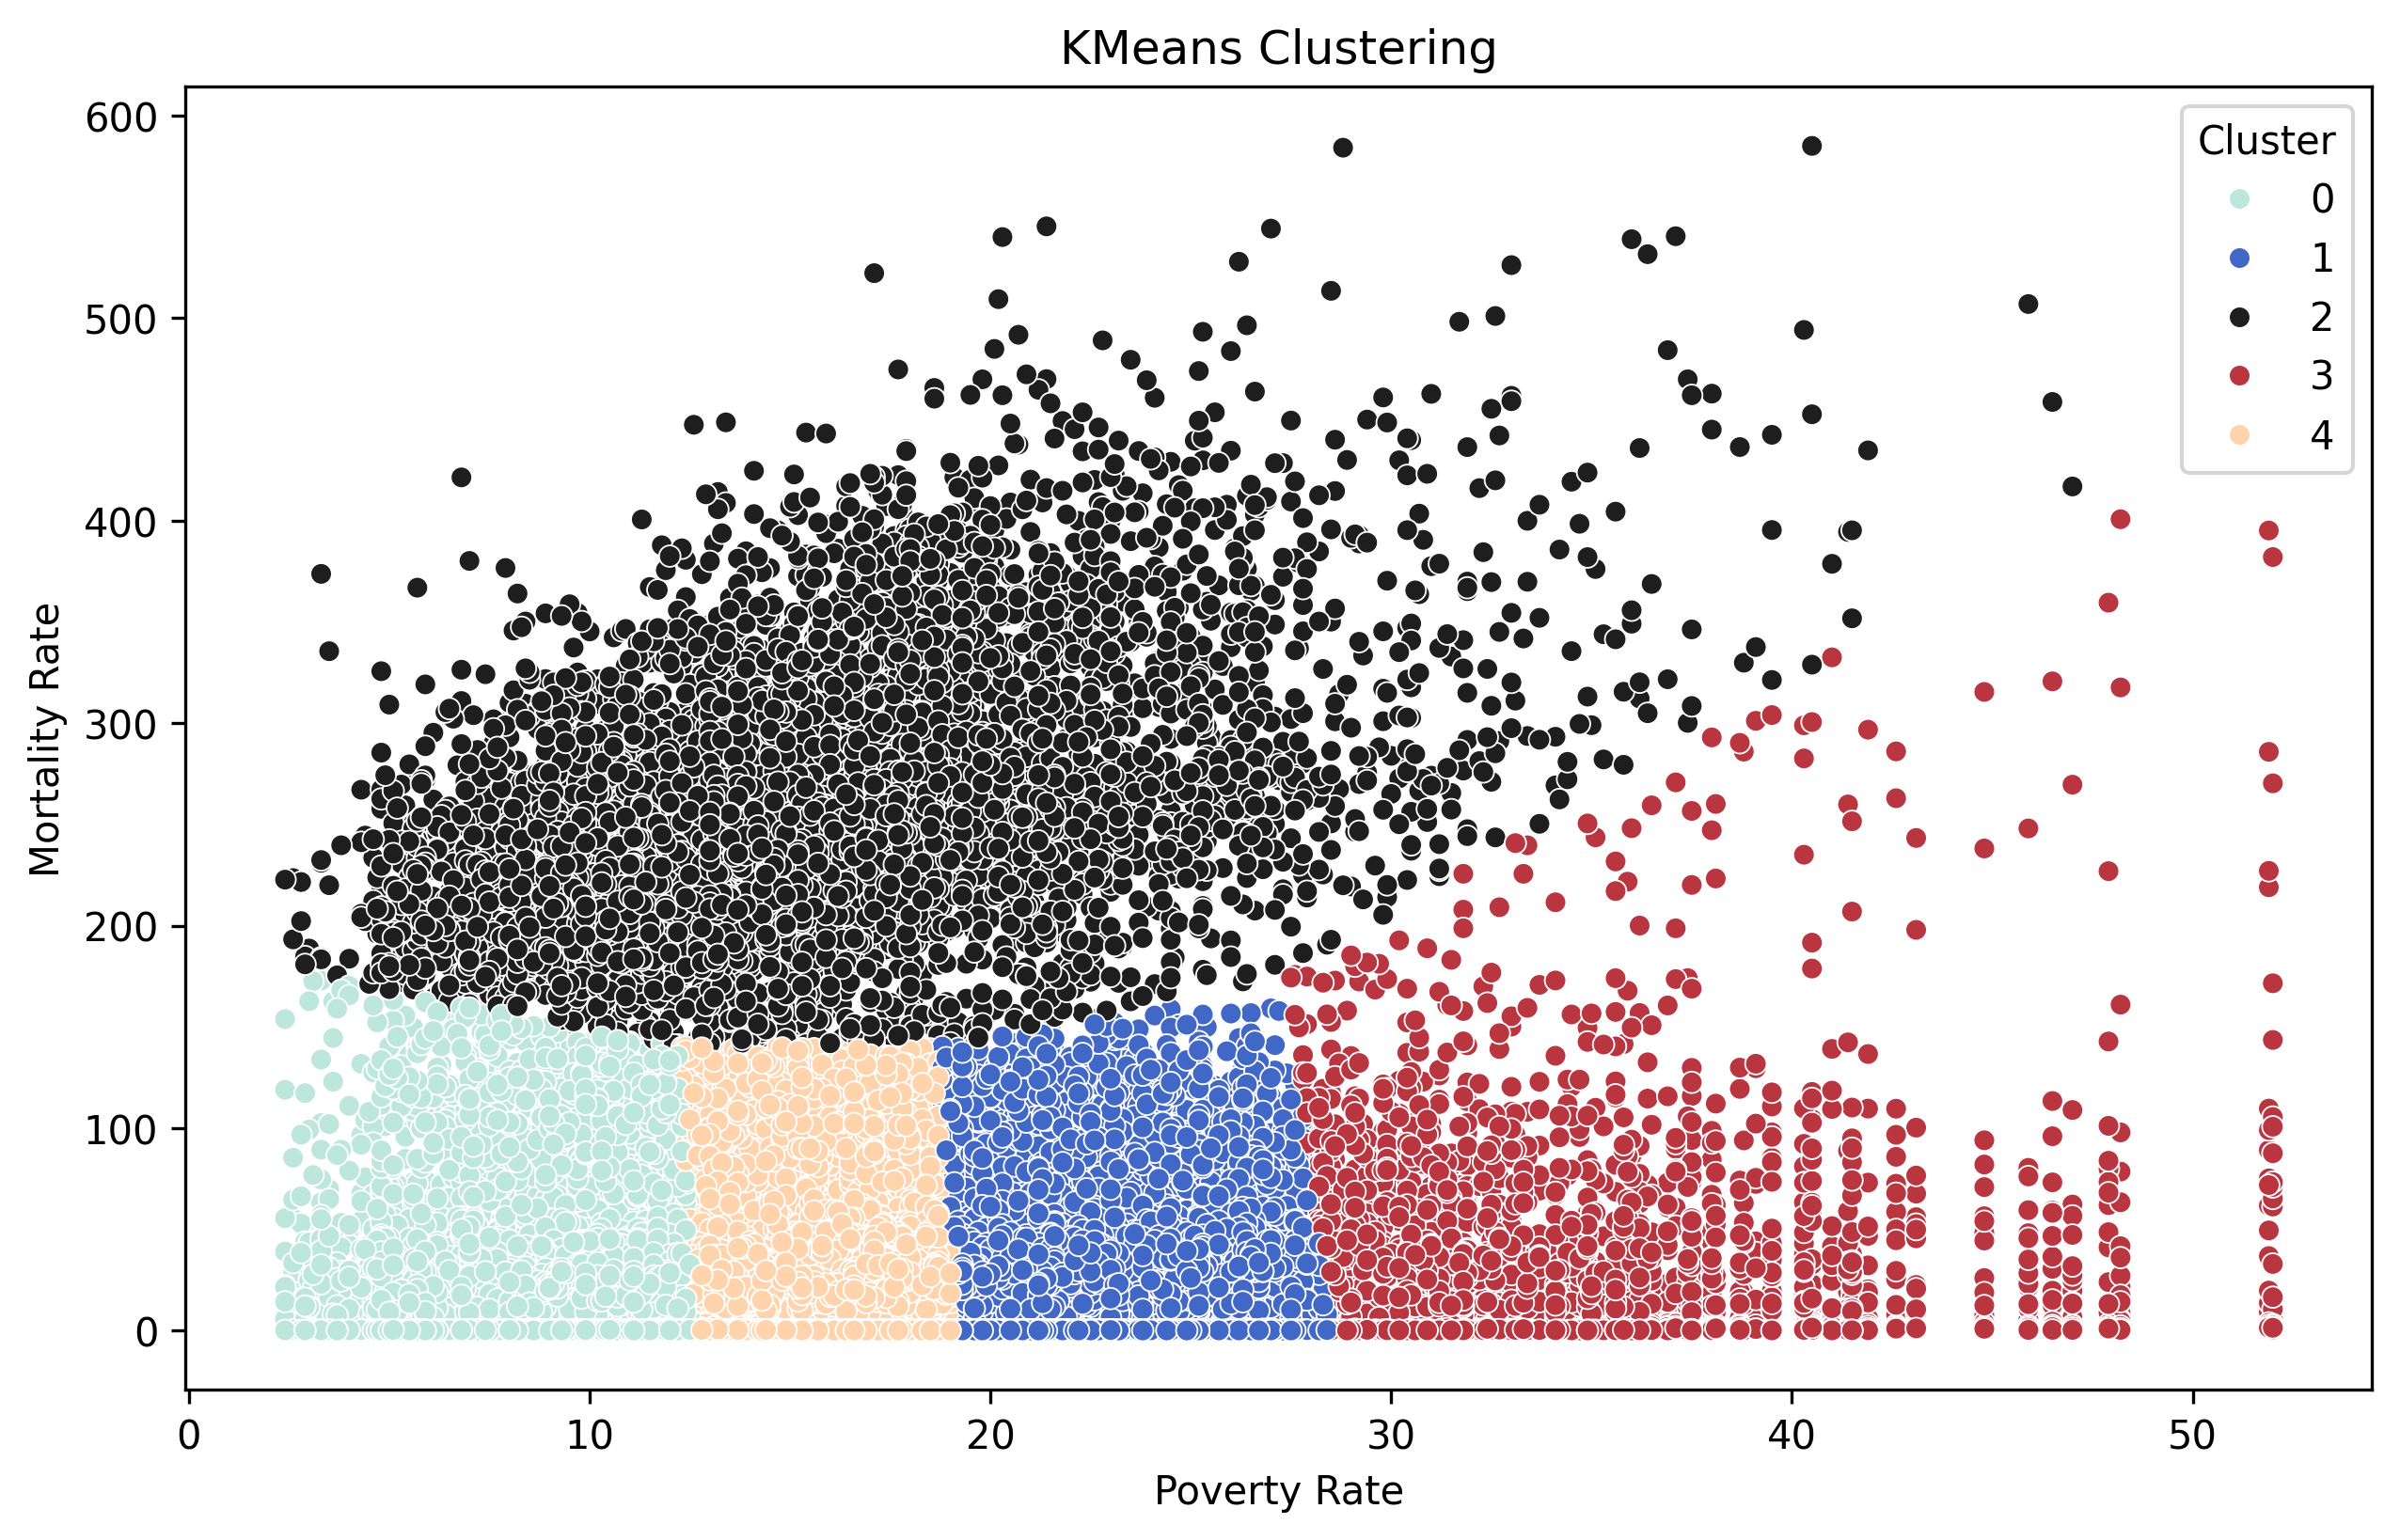

In [7]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x=df['poverty'], y=df['mortality_rate_2014_max'], hue=df['cluster'],  s=30, palette="icefire")
plt.title('KMeans Clustering')
plt.xlabel('Poverty Rate')
plt.ylabel('Mortality Rate')
plt.legend(title='Cluster')
plt.show()